<h1><center><b>ChemistrAI</b></center></h1>

# **Context**

The third part of this development consists of creating the inference function together with the efficientnet (encoder) and the attention decoder.

Then I will make the projections on the test dataset

In [ ]:
#Libraries

import os
from matplotlib import pyplot as plt

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
import numpy as np
import pandas as pd
import torch

import sys
sys.path.append('timm-pytorch-image-models/pytorch-image-models-master')

import os
import gc
import re
import math
import time
import random
import shutil
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

from tqdm.auto import tqdm

import Levenshtein
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, Blur
    )
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Configuration

In [ ]:
class CFG:
    debug          = True
    apex           = False
    max_len        = 275
    print_freq     = 250
    num_workers    = 4
    model_name     = 'efficientnet_b2'
    enc_size       = 1408
    samp_size      = 500000
    size           = 288
    scheduler      = 'CosineAnnealingLR' 
    epochs         = 1 
    T_max          = 4  
    encoder_lr     = 1e-4
    decoder_lr     = 4e-4
    min_lr         = 1e-6
    batch_size     = 32
    weight_decay   = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm  = 10
    attention_dim  = 256
    embed_dim      = 512
    decoder_dim    = 512
    decoder_layers = 2     # number of LSTM layers
    dropout        = 0.5
    seed           = 42
    n_fold         = 5
    trn_fold       = 0 
    train_path     = 'wowdao-generative-ai-applications-dataset/data/test/'
    prep_path      = 'tokenizer-and-preprocessing-of-chemical-formulas/'
    pred_model     = 'model-effientnet/best_model.pth'

In [ ]:
#Function to define the path of the images inside the folder
def get_test_file_path(image_id):
    return CFG.train_path + "{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

# **Tokenizer**

In [ ]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load(CFG.prep_path + 'tokenizer.pth')
print(f"Vocabulary: {tokenizer.stoi}")

Vocabulary: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 93, '

# **Logger**

In [ ]:
# Metric
def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score


def init_logger(log_file='inference.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

#Fix the random seed
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False # True

seed_torch(seed = CFG.seed)

In [ ]:
# Function to process the testing image and return the array 3d
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df            = df
        self.file_paths    = df['file_path'].values
        self.transform     = transform
        self.fix_transform = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        h, w, _ = image.shape
        if h > w:
            image = self.fix_transform(image=image)['image']
        if self.transform:
            augmented = self.transform(image=image)
            image     = augmented['image']
        return image

In [ ]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# **CNN Encoder**

In [ ]:
#CNN Encoder
class Encoder(nn.Module):
    def __init__(self, model_name = CFG.model_name, pretrained = False):
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained = pretrained)

    def forward(self, x):
        bs       = x.size(0)
        features = self.cnn.forward_features(x)
        features = features.permute(0, 2, 3, 1)
        return features

# **RNN Decoder**

In [ ]:
#RNN Decoder

#Attention module
class Attention(nn.Module):
    '''
    Attention network for calculate attention value
    '''
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        '''
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        '''
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att    = nn.Linear(attention_dim, 1)            # linear layer to calculate values to be softmax-ed
        self.relu        = nn.ReLU()
        self.softmax     = nn.Softmax(dim = 1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1  = self.encoder_att(encoder_out)     # (batch_size, num_pixels, attention_dim)
        att2  = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att   = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)                 # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha
    
    
#Custom LSTM cell
def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size, **kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


#Decoder
class DecoderWithAttention(nn.Module):
    '''
    Decoder network with attention network used for training
    '''

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout, num_layers):
        '''
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param num_layers: number of the LSTM layers
        :param dropout: dropout rate
        '''
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim   = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim     = embed_dim
        self.decoder_dim   = decoder_dim
        self.vocab_size    = vocab_size
        self.dropout       = dropout
        self.num_layers    = num_layers
        self.device        = device
        self.attention     = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding     = nn.Embedding(vocab_size, embed_dim)                 # embedding layer
        self.dropout       = nn.Dropout(p = self.dropout)
        self.decode_step   = nn.ModuleList([LSTMCell(embed_dim + encoder_dim if layer == 0 else embed_dim, embed_dim) for layer in range(self.num_layers)]) # decoding LSTMCell        
        self.init_h        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta        = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid       = nn.Sigmoid()
        self.fc            = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()                                      # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune = True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim = 1)
        h = [self.init_h(mean_encoder_out) for i in range(self.num_layers)]  # (batch_size, decoder_dim)
        c = [self.init_c(mean_encoder_out) for i in range(self.num_layers)]
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        '''
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        '''
        batch_size       = encoder_out.size(0)
        encoder_dim      = encoder_out.size(-1)
        vocab_size       = self.vocab_size
        encoder_out      = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels       = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim = 0, descending = True)
        encoder_out      = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state, initialize cell_vector and hidden_vector
        prev_h, prev_c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions    = torch.zeros(batch_size, max(decode_lengths), vocab_size, device = self.device)
        alphas         = torch.zeros(batch_size, max(decode_lengths), num_pixels, device = self.device)
        
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                prev_h[-1][:batch_size_t])
            gate = self.sigmoid(self.f_beta(prev_h[-1][:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            
            for i, rnn in enumerate(self.decode_step):
                # recurrent cell
                h, c = rnn(input, (prev_h[i][:batch_size_t], prev_c[i][:batch_size_t])) # cell_vector and hidden_vector

                # hidden state becomes the input to the next layer
                input = self.dropout(h)

                # save state for next time step
                prev_h[i] = h
                prev_c[i] = c
                
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :]      = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        
        # size variables
        batch_size  = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size  = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels  = encoder_out.size(1)
        
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype = torch.long, device = self.device) * tokenizer.stoi['<sos>']
        embeddings    = self.embedding(start_tockens)
        
        # initialize hidden state and cell state of LSTM cell
        h, c        = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size, device = self.device)
        
        # predict sequence
        end_condition = torch.zeros(batch_size, dtype=torch.long, device = self.device)
        for t in range(decode_lengths):
            awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
            gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
            awe        = gate * awe
            
            input = torch.cat([embeddings, awe], dim=1)
 
            for j, rnn in enumerate(self.decode_step):
                at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
                input = self.dropout(at_h)
                h[j]  = at_h
                c[j]  = at_c
            
            preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        
        return predictions
    
    # beam search
    def forward_step(self, prev_tokens, hidden, encoder_out, function):
        
        h, c = hidden
        #h, c = h.squeeze(0), c.squeeze(0)
        h, c = [hi.squeeze(0) for hi in h], [ci.squeeze(0) for ci in c]
        
        embeddings = self.embedding(prev_tokens)
        if embeddings.dim() == 3:
            embeddings = embeddings.squeeze(1)
            
        awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
        gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
        awe        = gate * awe
        
        input = torch.cat([embeddings, awe], dim = 1)
        for j, rnn in enumerate(self.decode_step):
            at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
            input = self.dropout(at_h)
            h[j]  = at_h
            c[j]  = at_c

        preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)

        #hidden = (h.unsqueeze(0), c.unsqueeze(0))
        hidden = [hi.unsqueeze(0) for hi in h], [ci.unsqueeze(0) for ci in c]
        predicted_softmax = function(preds, dim = 1)
        
        return predicted_softmax, hidden, Nonea

# **Testing dataset**

In [ ]:
test = pd.read_csv('wowdao-generative-ai-applications-dataset/test.csv')
test['file_path'] = test['image_id'].apply(get_test_file_path)
display(test.head())

,image_id,InChI,file_path
0,00000d2a601c,InChI=1S/H2O/h1H2,../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/00000d2a601c.png
1,00001f7fc849,InChI=1S/H2O/h1H2,../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/00001f7fc849.png
2,000037687605,InChI=1S/H2O/h1H2,../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/000037687605.png
3,00004b6d55b6,InChI=1S/H2O/h1H2,../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/00004b6d55b6.png
4,00004df0fe53,InChI=1S/H2O/h1H2,../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/00004df0fe53.png


# **Inference function**

In [ ]:
def inference(test_loader, encoder, decoder, tokenizer, device):
    
    encoder.eval()
    decoder.eval()
    
    text_preds = []
    tk0 = tqdm(test_loader, total = len(test_loader))
    
    for images in tk0:
        
        images = images.to(device)
        
        with torch.no_grad():
            features = encoder(images)
            predictions = decoder.predict(features, CFG.max_len, tokenizer)
            
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
        
    text_preds = np.concatenate(text_preds)
    
    return text_preds

# **Loading model (Encoder & Decoder)**

In [ ]:
#Loading model
states = torch.load(CFG.pred_model, map_location = torch.device('cpu'))

encoder = Encoder(CFG.model_name, pretrained = False)
encoder.load_state_dict(states['encoder'])
encoder.to(device)

decoder = DecoderWithAttention(attention_dim = CFG.attention_dim, 
                               embed_dim     = CFG.embed_dim, 
                               encoder_dim   = CFG.enc_size,
                               decoder_dim   = CFG.decoder_dim,
                               num_layers    = CFG.decoder_layers,
                               vocab_size    = len(tokenizer), 
                               dropout       = CFG.dropout, 
                               device        = device)
decoder.load_state_dict(states['decoder'])
decoder.to(device)

del states; gc.collect()

69

# **Predictions**

In [ ]:
# Predictions
test_dataset = TestDataset(test, transform = get_transforms(data = 'valid'))
test_loader  = DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = CFG.num_workers)
predictions  = inference(test_loader, encoder, decoder, tokenizer, device)
test['InChI'] = [f"InChI=1S/{text}" for text in predictions]
display(test.head())

  0%|          | 0/6313 [00:00<?, ?it/s]

,image_id,InChI,file_path
0,00000d2a601c,"InChI=1S/C11H16BrN4/c1-8-6-14-11(16-9)9(15-2)9(15-3)4-5-14-7-13-8/h4-5,8,14H,6H2,1-3H3",../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/00000d2a601c.png
1,00001f7fc849,"InChI=1S/C14H17ClN3/c1-2-3-11-4-5-13(7-7-13)14-11-17-14-7-9-16-15(15)10-15/h4-7,10,13H,2,3,8-9,11H2,1H3,(H,17,18)",../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/00001f7fc849.png
2,000037687605,"InChI=1S/C16H12BrN2O/c1-10(17)16-9-15(18)18-10-15(18)10-18-9-11-4-2-3-5-13(11)14/h2-7,10,16H,1H3",../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/000037687605.png
3,00004b6d55b6,"InChI=1S/C15H19FN4O/c1-17(2,3)16-11(18)8-15(19-15)15-9-11(17)6-6-12(15)18-4/h5-7,10,16H,8H2,1-4H3,(H,17,19)",../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/00004b6d55b6.png
4,00004df0fe53,"InChI=1S/C9H10BrNO/c1-6-4-5(2-3-6)6(7)6(9)9(10)12/h4-6,9H,1-3H3/t5-,7-,7-,7-,8+,9+,9+/m1/s1",../input/wowdao-generative-ai-applications-dataset/data/test/0/0/0/00004df0fe53.png


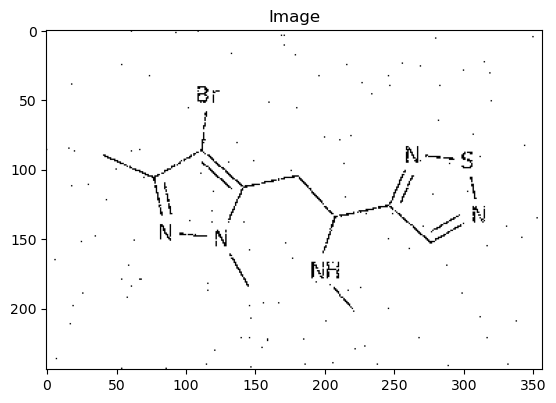

InChI=1S/C11H16BrN4/c1-8-6-14-11(16-9)9(15-2)9(15-3)4-5-14-7-13-8/h4-5,8,14H,6H2,1-3H3


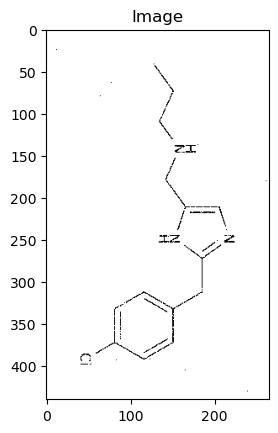

InChI=1S/C14H17ClN3/c1-2-3-11-4-5-13(7-7-13)14-11-17-14-7-9-16-15(15)10-15/h4-7,10,13H,2,3,8-9,11H2,1H3,(H,17,18)


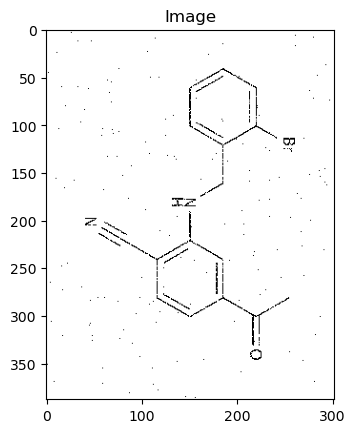

InChI=1S/C16H12BrN2O/c1-10(17)16-9-15(18)18-10-15(18)10-18-9-11-4-2-3-5-13(11)14/h2-7,10,16H,1H3


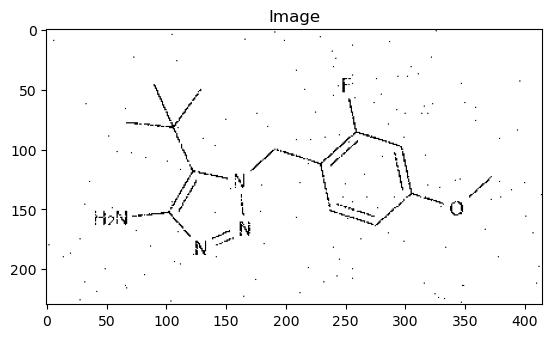

InChI=1S/C15H19FN4O/c1-17(2,3)16-11(18)8-15(19-15)15-9-11(17)6-6-12(15)18-4/h5-7,10,16H,8H2,1-4H3,(H,17,19)


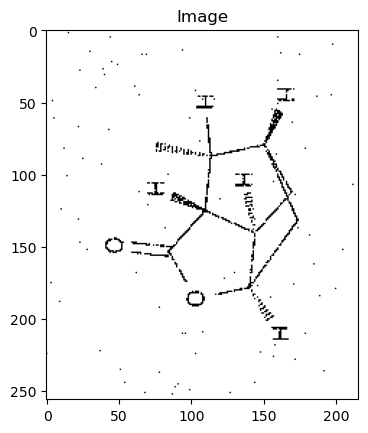

InChI=1S/C9H10BrNO/c1-6-4-5(2-3-6)6(7)6(9)9(10)12/h4-6,9H,1-3H3/t5-,7-,7-,7-,8+,9+,9+/m1/s1


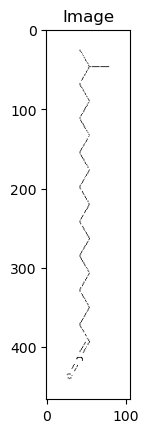

InChI=1S/C18H34N2/c1-3-4-5-6-7-8-9-10-11-12-14-15-17-18(2)19/h14-15,18H,3-13,16H2,1-2H3


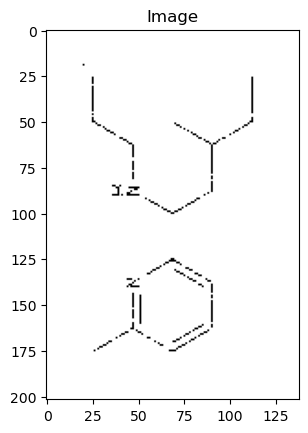

InChI=1S/C14H23N2/c1-4-9-14-12-7-5-7-12(11(11)2)14-11-13(3)4/h7-9,12,15H,4-6,10-11H2,1-3H3


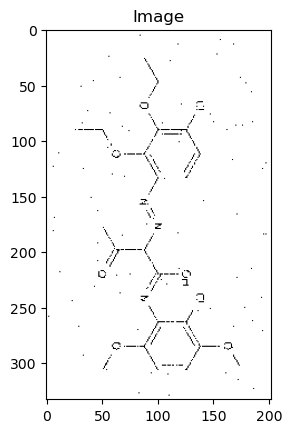

InChI=1S/C23H27ClN3O5S/c1-5-28-19-11-15(25-4)17(27-5)17(11-16)27-19(27)13-9-12(2)24-21(14)22(28)28-17(13)12-7-8-12(24)8-9-15/h6-10,15H,5H2,1-4H3,(H,25,28)


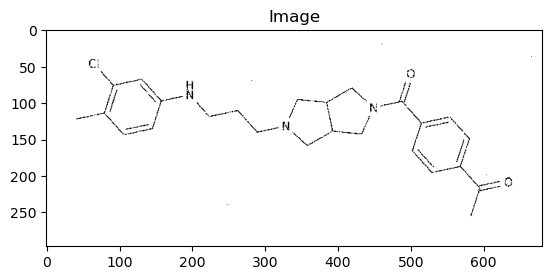

InChI=1S/C25H29ClN3O2/c1-18-4-5-21(11-20(22)2)25-11-14-27(13-12-27)19-28-19-25(29)24-9-10-24(13-14-27)25(29)14-20-3-5-20/h3-6,14-16,21H,6-12,16H2,1-2H3,(H,28,31)


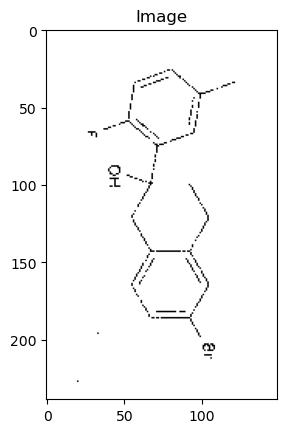

InChI=1S/C16H14BrFNO/c1-10-3-4-12(7-10(13)2)11-5-8-15(18)10-12(11)7-10(16)3-7-15/h2-4,8,11,15,17H,5-6,8H2,1H3


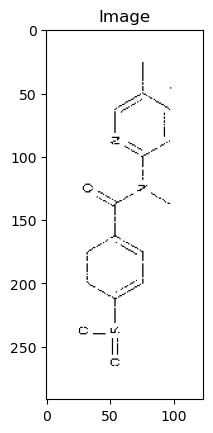

InChI=1S/C15H17N2O3/c1-11-4-5-11(5-6-12)12(2)15-14(18)9-14(18)15-9-11-3-6-13(16)19-8-10/h3-7,10H,8H2,1-2H3,(H,17,18)


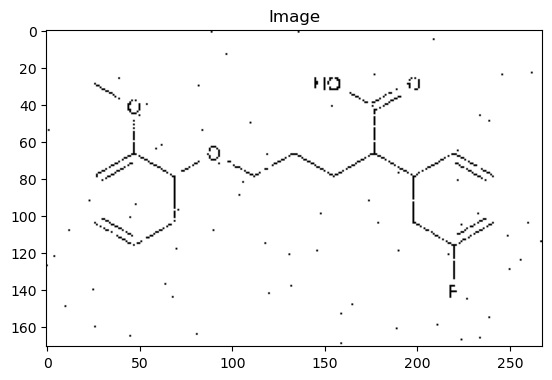

InChI=1S/C18H20FNO3/c1-23-16-7-3-2-4-13(16)9-8-15(19)19(21)21-12-10-14-7-5-9-16(18)13-15/h2-5,8-9,12,16,19H,6-8,11-12H2,1H3,(H,21,23)


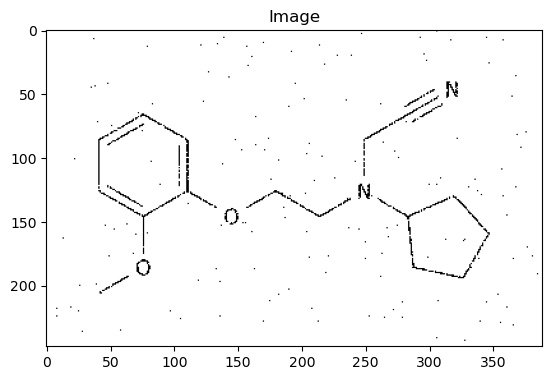

InChI=1S/C16H20N2O2/c1-19-13-15(10-15)18-10-8-15(17)16-9-5-10-18(16)18-6-2-3-8-17/h4-5,9-10,13,16H,2,3,6-8,11-13H2,1H3


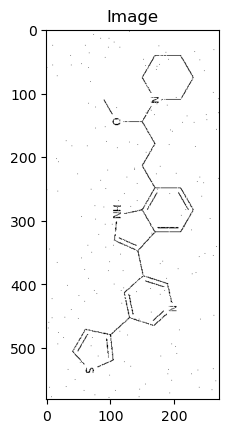

InChI=1S/C25H28N4O2/c1-29-21-9-5-14-27(19)23(28)17-28-21-9-6-16(9-17(21)11-21-23)23-19-6-3-4-9-21(19)27-20(2)27/h3-4,7-9,13-15,19,22H,2,5-7,10-12,15H2,1H3


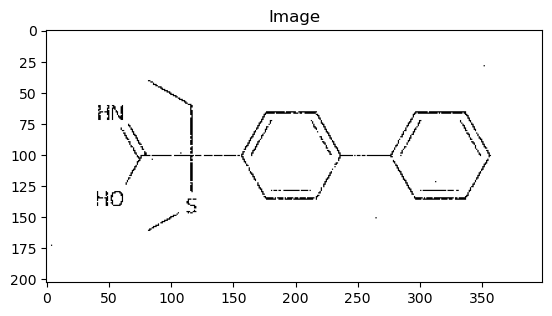

InChI=1S/C17H19NO2/c1-3-16(16(19)19-13-9-6-4-7-10-14)15(17)13-7-5-7-12(2)11-13/h3-11,16H,2,13H2,1H3,(H,18,19)


In [ ]:
for index,row in test[:15].iterrows():
    image_id = row["image_id"]
    image_path = "wowdao-generative-ai-applications-dataset/data/test/"+image_id[0]+"/"+image_id[1]+"/"+image_id[2]+"/"+image_id+".png"
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    plt.imshow(gray)
    plt.title('Image')
    plt.show()
    print(row["InChI"])
    print("="*64)